# Calculation and Visualization of Effective Potentials

- Based on pseudopotential calculations first demonstrated by Hans Georg Dehmelt
- Good overview by Dieter Gerlich in Advances in Chemical Physics (1992) Vol. 82, Chapter 1 (ISBN:0470141921)

### Outline of SIMION Effective Potentials determination:

1. Take an instance of a potential array in graphical units (aka a field matrix) exported from SLTools
2. Take the x,y,z field components and divide each by total mm in each dimension: ex = (ex / pa.dx_mm) to get V/mm
3. Take the root of the sum of the squares for each dimension
4. Divide this value by the scale dfined in the SIMION pa instance to get V/m

5. These values (array "E") are used in the psuedopoential equation for a given point in graphical units
6. E is multiplied by 1000 to go back to V/mm
7. pseudopoential at given point is (q/(4mΩ^2))*E^2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import sys, os
import time

In [3]:
# Simplified Input Units

Da = 242.0                              # Ion Mass [Daltons]
z = 1                                   # z        [charge]
freq = 1 * (10**6)                      # RF Freq  [Hz]
scale = 0.05                            # SIMION scaling fac [mm/gu] 

### On Scaling Field Voltages

field units are field strength, conventionally V/cm. When calculating pseudopotentials, the field strengths need to be in V/m. SIMION exports them in volts per grid unit (V/gu), which can be converted to V/mm by multiplying by gu/mm (inverse of scale, so divide by the scale). This should then be multiplied by 1000 mm / m to get V / mm before employing the pseudopotential equation.

Note:
- From SIMION Revision NOTES: "8.1.0-TEST14 - mm_per_gu was renamed to scale."
- SIMION lua extracts scale from pa workbook so it is likely this 0.05 value we see referenced
- They also extract dx_mm, dy_mm, dz_mm. These values also seem to be 0.05 gu/mm and can be found in the file header. But they use separate instances of the variable, could be an imperfect coding example or maybe they had two different values at some point
- interestingly, both methods (PNNL and SIMION) divide by the scale twice. The PNNL matlab divides the sum of squares by scale^2 explicitly, (and neglects to take the root of that sum). 
- The SIMION lua divides by the scale in another variable name, (dx_mm, or mm per grid unit = 0.05) when summing the vector components, and again by the term scale, which seems to represent mm per grid unit as well. It seems it is simply replicated for each dimension xyz.
- The SIMION lua converts mm to m outside the field function so we do the same here

In [4]:
## Stock SLIM pas file names
rfname = 'patxts/spl_rf.patxt'  # just RF electrodes, ±140 Vp-p
twname = 'patxts/spl_tw.patxt'  # just TW electrodes, ±11 V
gname = 'patxts/spl_g.patxt'    # just the guard electrodes, 14 V

dc_headers = ['x','y','z','elec','vdc']
rf_headers = ['x','y','z','elec','rfe_x', 'rfe_y', 'rfe_z']

In [5]:
# convert to pandas for interacting with columns
g_df  = pd.read_csv(gname, delimiter=' ', names = dc_headers, skiprows=21, skipfooter=2, engine='python')
tw_df = pd.read_csv(twname, delimiter=' ', names = dc_headers, skiprows=21, skipfooter=2, engine='python')
rf_df = pd.read_csv(rfname, delimiter=' ', names = rf_headers, skiprows = 21, skipfooter=2, engine='python')

In [6]:
# get simulation dimensions
pa_x, pa_y, pa_z = max(rf_df['x']), max(rf_df['y']), max(rf_df['z'])

x_vals = np.arange(0, pa_x, 1)
y_vals = np.arange(0, pa_y, 1)
z_vals = np.arange(0, pa_z, 1)

In [7]:
## main functions
def find_row(df, coords):
    '''find a row given coords in potential df'''
    x,y,z = coords[0], coords[1], coords[2]
    row = df.loc[(df["x"] == x) & (df["y"] == y) & (df["z"] == z)]
    return row

def field(pa_df, scale, coords):
    '''
    get magnitude of field (V/mm) at point (x,y,z) in grid units
    copied largely from SIMON examples / pseudopotential / trap.lua
    '''
    # get field values for coordindates
    entry = find_row(pa_df, coords) # go to row for coords of interest
    ex, ey, ez = entry["rfe_x"], entry["rfe_y"], entry["rfe_z"] # extract V / gu
    ex, ey, ez = ex / scale , ey / scale , ez / scale # V / mm
    
    # square-root sum of squares for each
    E = np.sqrt(ex**2 + ey**2 + ez**2)
    
    # divide that answer by scale
#     E = E / scale
    # this is one question I have about the lua code - they divide by dx-mm = scale = 0.05
    # but then divide the rooted sum of squares by the scale again
    
    # anyway supposedly here we return field strength values in V/mm, not far from standard
    return E

def calculate_pseudopotential(pa_df, coords, mass, charge, frequency):
    '''
    get pseudopotential values for new 3d matrix
    also copied from SIMON examples / pseudopotential / trap.lua
    '''
    q = charge * (1.602 * (10**-19))        # convert ionic charge to elementary charges
    m = mass * (0.001 / (6.023 * (10**23))) # convert mass from Da to kg
    Ω = frequency * 2 * np.pi               # convert Rf freq Ω to angular frequency units (rad/s)
    k = q / (4 * m * Ω**2)                  # get constant k (for m, Ω, q)
    
    # get field value at point xyz from field()
    E = field(pa_df, scale, coords) * 1000  # V/mm * 1000 mm/m
    pseudo = k * E**2
    
    return pseudo

def yz_slicer(pa_df, x_point):
    '''cuts a y/z slice (face view) at given X (usually 0)'''
    yz_slice = pa_df.loc[pa_df["x"]==x_point]
    return yz_slice.reset_index(drop=True)

def xz_slicer(pa_df, y_point):
    '''cuts a y/z slice (face view) at given X (usually 0)'''
    xz_slice = pa_df.loc[pa_df["y"]==y_point]
    return xz_slice.reset_index(drop=True)

def add_pseudo_column(pa_df, mass, charge, freq, retBool=True):
    '''
    For all rows in supplied df, calculate pseudopotential
    pseudopotential is added to pa_df as a column and returned if retBool=True
    '''
    pseudo_col = np.zeros(pa_df["x"].size) # create empty
    for n, row in pa_df.iterrows():
        coords = (int(row[0]), int(row[1]), int(row[2])) # gx, gy, gz
        pseudo = calculate_pseudopotential(pa_df, coords, mass, charge, freq) # use built method
        pseudo_col[n] = pseudo # fill empty array
    if retBool:
        return pseudo_col

In [8]:
rf_yz_slc = yz_slicer(rf_df, 0)
tw_yz_slc = yz_slicer(tw_df, 0)
g_yz_slc = yz_slicer(g_df, 0)

pseudo_column = add_pseudo_column(rf_yz_slc, Da, z, freq)

rf_yz_slc["pseudo"] = pseudo_column

/tmp/ipykernel_15750/3471242121.py:62: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coords = (int(row[0]), int(row[1]), int(row[2])) # gx, gy, gz
/tmp/ipykernel_15750/3471242121.py:64: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  pseudo_col[n] = pseudo # fill empty array


In [9]:
def yz_to_mtx(yz_slice, data_col):
    slice_mtx = np.zeros((max(yz_slice["y"])+1, max(yz_slice["z"])+1))
    for n, row in yz_slice.iterrows():
        x, y, z = int(row['x']), int(row['y']), int(row['z'])
        potential = float(row[data_col])
        slice_mtx[y, z] = potential
    return slice_mtx

def xz_to_mtx(xz_slice, data_col):
    slice_mtx = np.zeros((max(xz_slice["x"])+1, max(xz_slice["z"])+1))
    for n, row in xz_slice.iterrows():
        x, y, z = int(row['x']), int(row['y']), int(row['z'])
        potential = float(row[data_col])
        slice_mtx[x, z] = potential
    return slice_mtx

In [10]:
def plot_yz_slices(yz_slices, p_col, mirrorBool=False, elecBool=True):
    '''display potential maps'''

    fig, axs = plt.subplots(nrows = len(yz_slices), squeeze=False, figsize=(10, 5))
    
    for n, yz_slice in enumerate(yz_slices):
        mtx = yz_to_mtx(yz_slice, p_col).T
        elec_mtx = yz_to_mtx(yz_slice, "elec").T
    
    
        if mirrorBool:
            mirror_mtx = np.flip(mtx, 0)
            full_mtx = np.vstack((mirror_mtx, mtx))
            mtx = full_mtx
            
            mirror_elec = np.flip(elec_mtx, 0)
            full_elec = np.vstack((mirror_elec, elec_mtx))
            elec_mtx = full_elec
    
    
        # plt.contour(mtx, cmap = 'bone', linestyles = 'dotted', alpha=0.75, norm = 'log')
        if elecBool:
            axs[n,0].imshow(elec_mtx, cmap='binary')
         
#         color_map = 'Spectral'
        color_map = 'RdYlGn_r'
        if p_col == "vdc":
            p1 = axs[n,0].imshow(mtx, cmap=color_map, alpha = 0.8)
        else:
            p1 = axs[n,0].imshow(mtx, cmap=color_map, alpha = 0.8, norm=colors.LogNorm())
    
    fig.colorbar(p1, location='bottom')
    plt.xlim(0, 244)
#     plt.ylim(5, 75)
    plt.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
    plt.show()
#     return fig

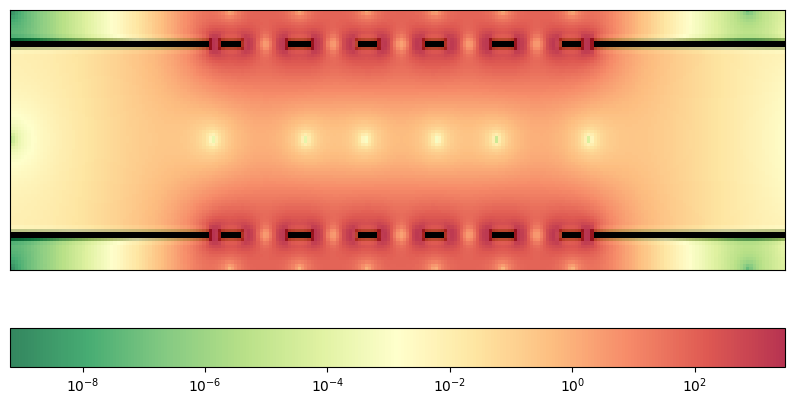

In [11]:
plot_yz_slices([rf_yz_slc], "pseudo", mirrorBool=True)